In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import keras

from sklearn.decomposition import IncrementalPCA
import pickle
import matplotlib.pyplot as plt

import data_splitter as ds
import data_loader as dl
import feature_extraction as fex

2023-04-18 14:46:09.868173: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-18 14:46:13.628156: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
metadata = pd.read_csv('train.csv')
len(metadata.image_id.unique())

54706

In [4]:
splitter = ds.DataSplitter(verbose=True)

Total patient_id in training set:  9530
Total patient_id in test set:  2383
Total image_id in training set:  43767
Total image_id in test set:  10939
Total patient_id in training set:  7624
Total patient_id in calibration set:  1906
Total image_id in training set:  35003
Total image_id in calibration set:  8764


In [5]:
# image id of all sample training set after split to calib and train set

train_img_ids = [id for k, v in splitter.trainset.items() for id in v]
print(len(train_img_ids))

35003


# Pre-train PCA on each fold's training split
The images reconstructed from **50 components** seem to preserve enough details and contrast of the original image. Components from normalized images have higher explained variance ratio at 50 components compared to standardized images.

In [6]:
# splitter.trainset is the training set in format of {patient_id: [image_id, ...]}
train_ids = splitter.trainset.keys()
label_by_img = splitter.labels

# getting cross-validation folds from training set
RANDOM_STATE = 42
cv_patient, cv_img = splitter.get_cv(n_splits=5, random_state=RANDOM_STATE)

Splitting training set into 5 stratified k-folds...
--Fold:  0
----Total patient_id in training set:  6099
----Total image_id in training set:  28031
----Total patient_id in validation set:  1525
----Total image_id in validation set:  6972
--Fold:  1
----Total patient_id in training set:  6099
----Total image_id in training set:  28016
----Total patient_id in validation set:  1525
----Total image_id in validation set:  6987
--Fold:  2
----Total patient_id in training set:  6099
----Total image_id in training set:  27937
----Total patient_id in validation set:  1525
----Total image_id in validation set:  7066
--Fold:  3
----Total patient_id in training set:  6099
----Total image_id in training set:  28025
----Total patient_id in validation set:  1525
----Total image_id in validation set:  6978
--Fold:  4
----Total patient_id in training set:  6100
----Total image_id in training set:  28003
----Total patient_id in validation set:  1524
----Total image_id in validation set:  7000


In [7]:
for i in range(5):
    print(len(cv_img[i]['train']))

28031
28016
27937
28025
28003


In [11]:
N_COMPONENTS = 50

BATCH_SIZE = 488 # losing as less samples as possible
IMG_SIZE = (256, 256, 1)

BASEPATH = '' # directory of images preprocessed as numpy arrays
EXTRACTOR_PATH = '../feature_extractors' # directory to save trained models


RANDOM_STATE = 42

train_time_512 = fex.cv_train_feature_extractor(
    cv_img = cv_img,
    patient_img_dict = splitter.trainset,
    batch_size = BATCH_SIZE,
    basepath = BASEPATH,
    img_size = IMG_SIZE,
    normalize = (0, 1),
    
    from_numpy = True,
    random_state = RANDOM_STATE,
    
    model_name = 'PCA',
    n_components = N_COMPONENTS, 
    extractor_path = EXTRACTOR_PATH,
    verbose = True,
    evaluate = False,
    return_none = True   
)

Fold:  0
Initialized PCA with n_components = 50
--Training batch  1
--Training batch  2
--Training batch  3
--Training batch  4
--Training batch  5
--Training batch  6
--Training batch  7
--Training batch  8
--Training batch  9
--Training batch  10
--Training batch  11
--Training batch  12
--Training batch  13
--Training batch  14
--Training batch  15
--Training batch  16
--Training batch  17
--Training batch  18
--Training batch  19
--Training batch  20
--Training batch  21
--Training batch  22
--Training batch  23
--Training batch  24
--Training batch  25
--Training batch  26
--Training batch  27
--Training batch  28
--Training batch  29
--Training batch  30
--Training batch  31
--Training batch  32
--Training batch  33
--Training batch  34
--Training batch  35
--Training batch  36
--Training batch  37
--Training batch  38
--Training batch  39
--Training batch  40
--Training batch  41
--Training batch  42
--Training batch  43
--Training batch  44
--Training batch  45
--Training batch

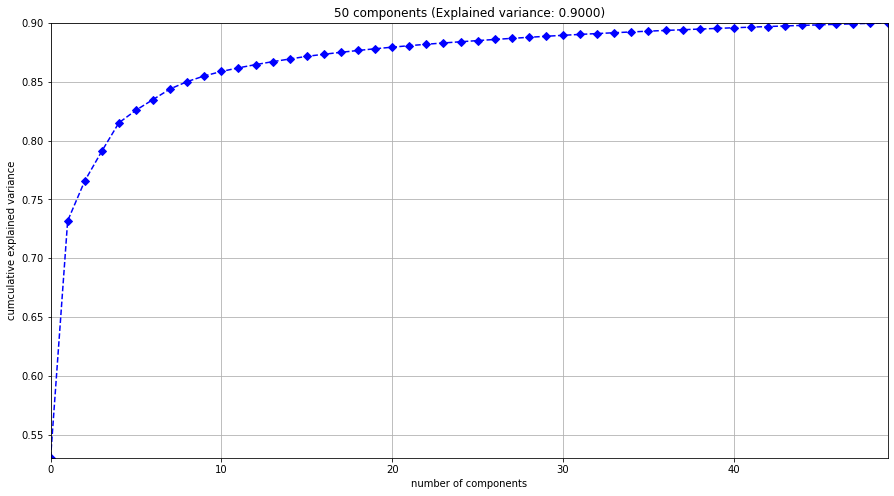

In [3]:
model = pickle.load(open('../feature_extractors/PCA_50_42_256_1.pkl', 'rb'))

fig, axs = plt.subplots(figsize=(15, 8))

axs.plot(model.explained_variance_ratio_.cumsum(), marker='D', linestyle="--", color='blue')
axs.set_title('50 components (Explained variance: {:.4f})'.format(model.explained_variance_ratio_.cumsum()[-1]))
axs.set_xlabel('number of components')
axs.set_ylabel('cumculative explained variance')
axs.margins(x=0,y=0)
plt.grid(axis='both')
plt.show()

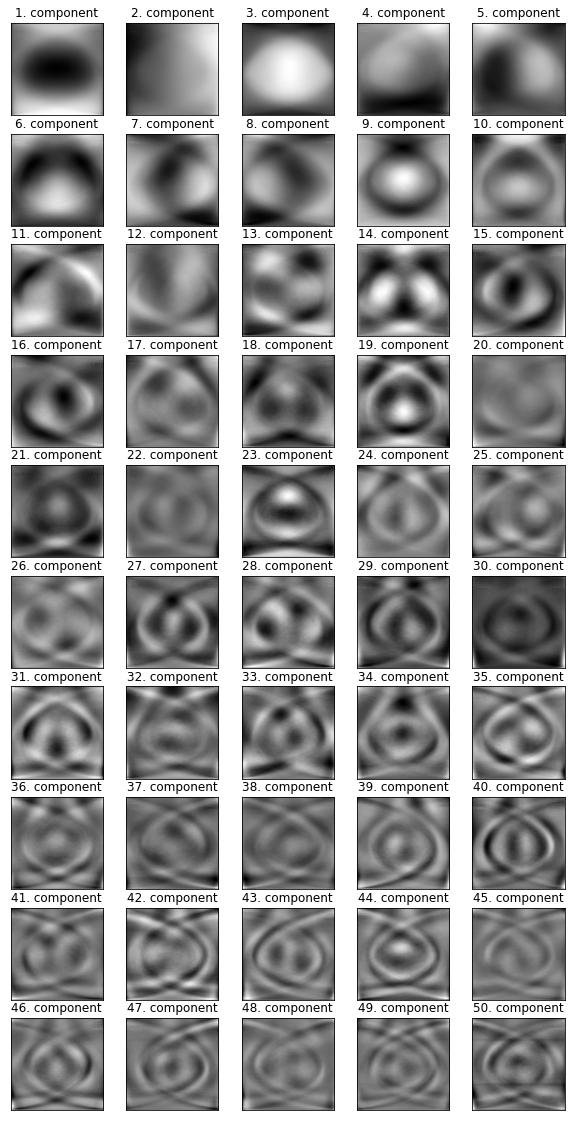

In [4]:
fig, axes = plt.subplots(10, 5, figsize=(10, 20), subplot_kw={'xticks': (), 'yticks': ()})

for i, (component, ax) in enumerate(zip(model.components_, axes.ravel())):
    ax.imshow(component.reshape(256, 256), cmap='gray')
    ax.set_title("{}. component".format((i + 1)))

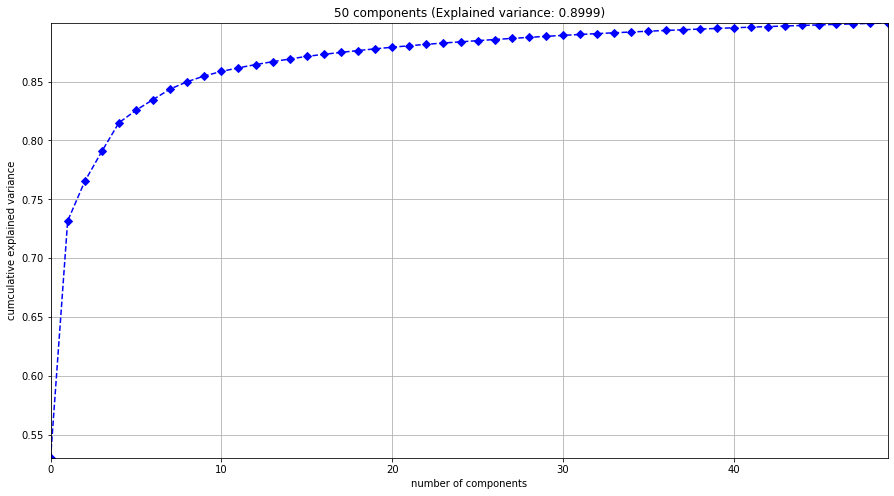

In [5]:
model = pickle.load(open('../feature_extractors/PCA_50_42_256_0.pkl', 'rb'))

fig, axs = plt.subplots(figsize=(15, 8))

axs.plot(model.explained_variance_ratio_.cumsum(), marker='D', linestyle="--", color='blue')
axs.set_title('50 components (Explained variance: {:.4f})'.format(model.explained_variance_ratio_.cumsum()[-1]))
axs.set_xlabel('number of components')
axs.set_ylabel('cumculative explained variance')
axs.margins(x=0,y=0)
plt.grid(axis='both')
plt.show()

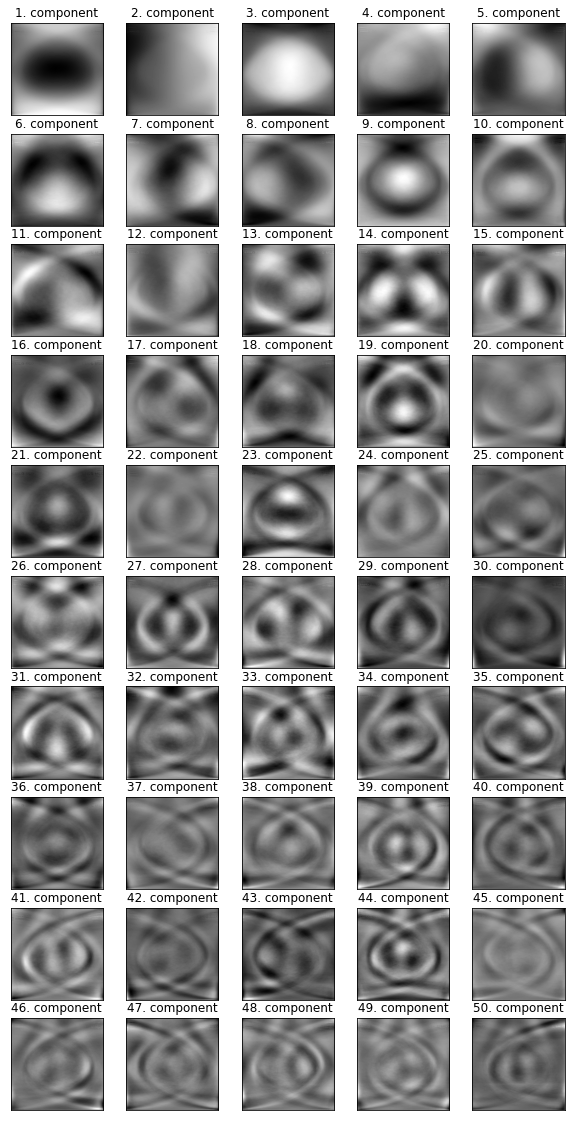

In [6]:
fig, axes = plt.subplots(10, 5, figsize=(10, 20), subplot_kw={'xticks': (), 'yticks': ()})

for i, (component, ax) in enumerate(zip(model.components_, axes.ravel())):
    ax.imshow(component.reshape(256, 256), cmap='gray')
    ax.set_title("{}. component".format((i + 1)))

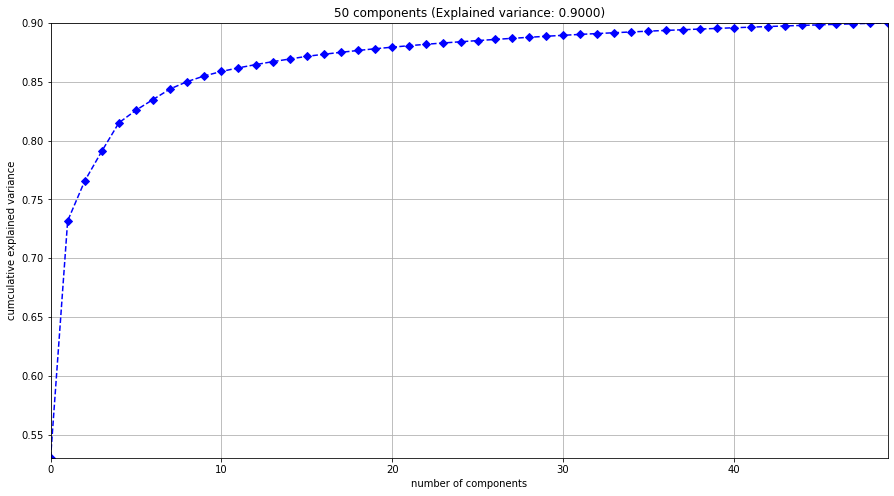

In [7]:
model = pickle.load(open('../feature_extractors/PCA_50_42_256_1.pkl', 'rb'))

fig, axs = plt.subplots(figsize=(15, 8))

axs.plot(model.explained_variance_ratio_.cumsum(), marker='D', linestyle="--", color='blue')
axs.set_title('50 components (Explained variance: {:.4f})'.format(model.explained_variance_ratio_.cumsum()[-1]))
axs.set_xlabel('number of components')
axs.set_ylabel('cumculative explained variance')
axs.margins(x=0,y=0)
plt.grid(axis='both')
plt.show()

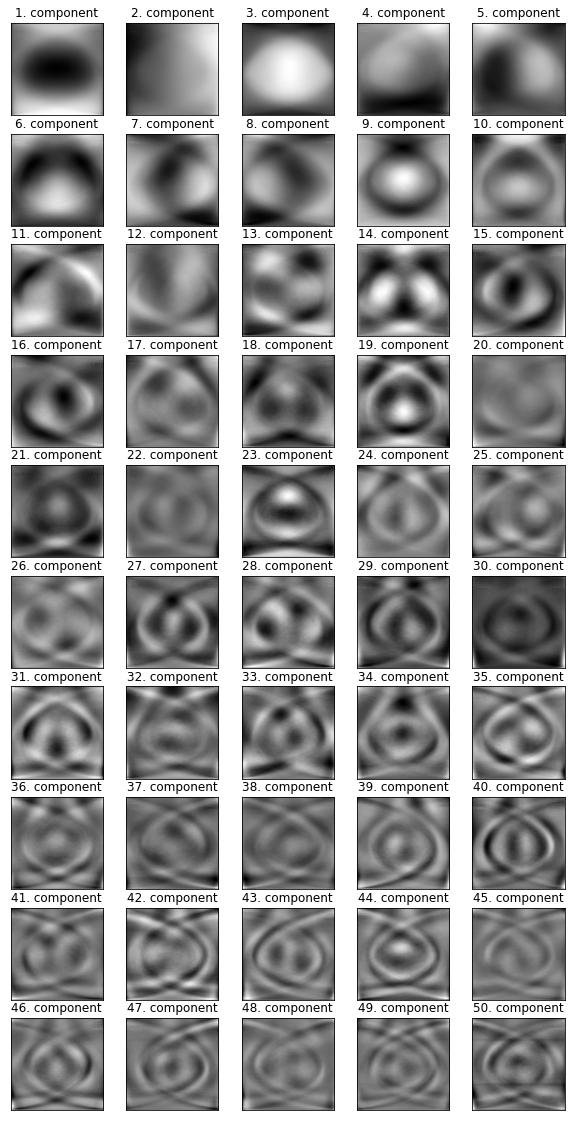

In [8]:
fig, axes = plt.subplots(10, 5, figsize=(10, 20), subplot_kw={'xticks': (), 'yticks': ()})

for i, (component, ax) in enumerate(zip(model.components_, axes.ravel())):
    ax.imshow(component.reshape(256, 256), cmap='gray')
    ax.set_title("{}. component".format((i + 1)))

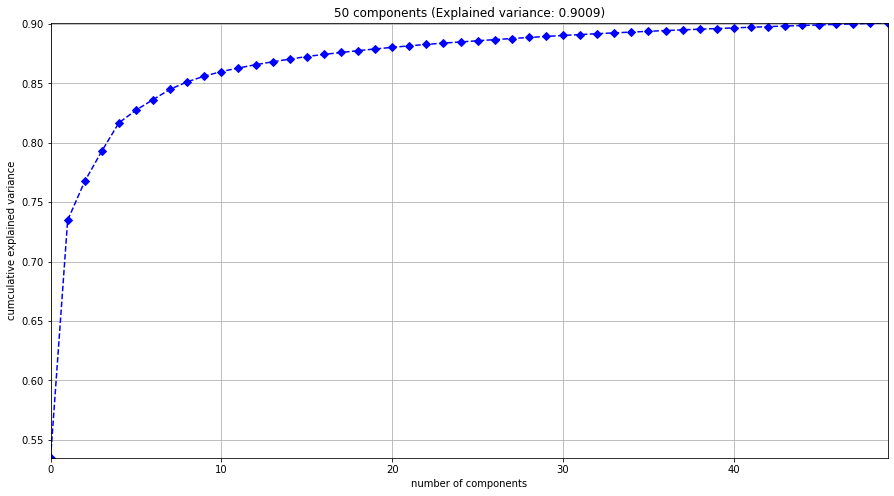

In [9]:
model = pickle.load(open('../feature_extractors/PCA_50_42_256_2.pkl', 'rb'))

fig, axs = plt.subplots(figsize=(15, 8))

axs.plot(model.explained_variance_ratio_.cumsum(), marker='D', linestyle="--", color='blue')
axs.set_title('50 components (Explained variance: {:.4f})'.format(model.explained_variance_ratio_.cumsum()[-1]))
axs.set_xlabel('number of components')
axs.set_ylabel('cumculative explained variance')
axs.margins(x=0,y=0)
plt.grid(axis='both')
plt.show()

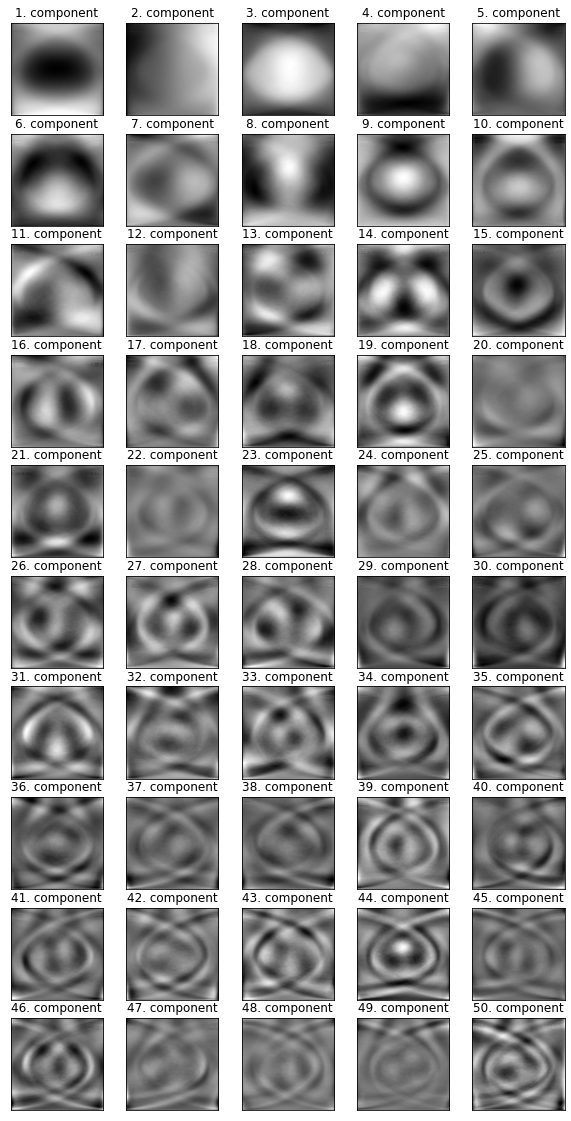

In [10]:
fig, axes = plt.subplots(10, 5, figsize=(10, 20), subplot_kw={'xticks': (), 'yticks': ()})

for i, (component, ax) in enumerate(zip(model.components_, axes.ravel())):
    ax.imshow(component.reshape(256, 256), cmap='gray')
    ax.set_title("{}. component".format((i + 1)))

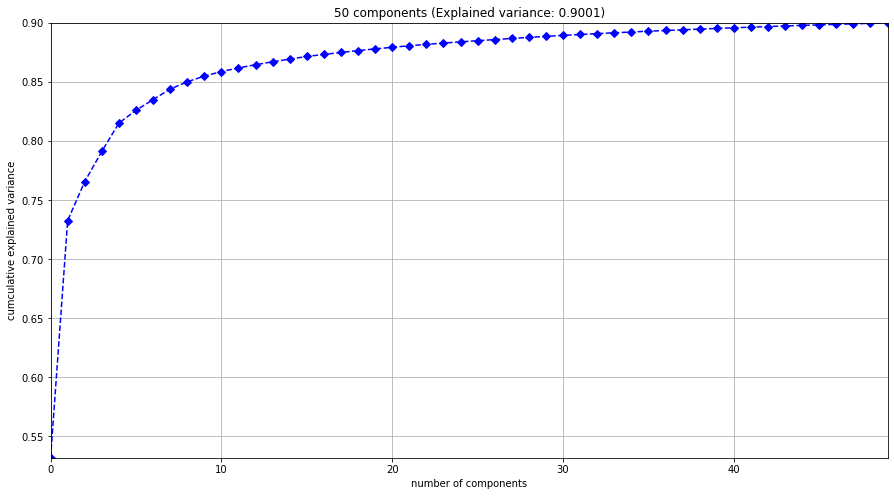

In [4]:
model = pickle.load(open('../feature_extractors/PCA_50_42_256_3.pkl', 'rb'))

fig, axs = plt.subplots(figsize=(15, 8))

axs.plot(model.explained_variance_ratio_.cumsum(), marker='D', linestyle="--", color='blue')
axs.set_title('50 components (Explained variance: {:.4f})'.format(model.explained_variance_ratio_.cumsum()[-1]))
axs.set_xlabel('number of components')
axs.set_ylabel('cumculative explained variance')
axs.margins(x=0,y=0)
plt.grid(axis='both')
plt.show()

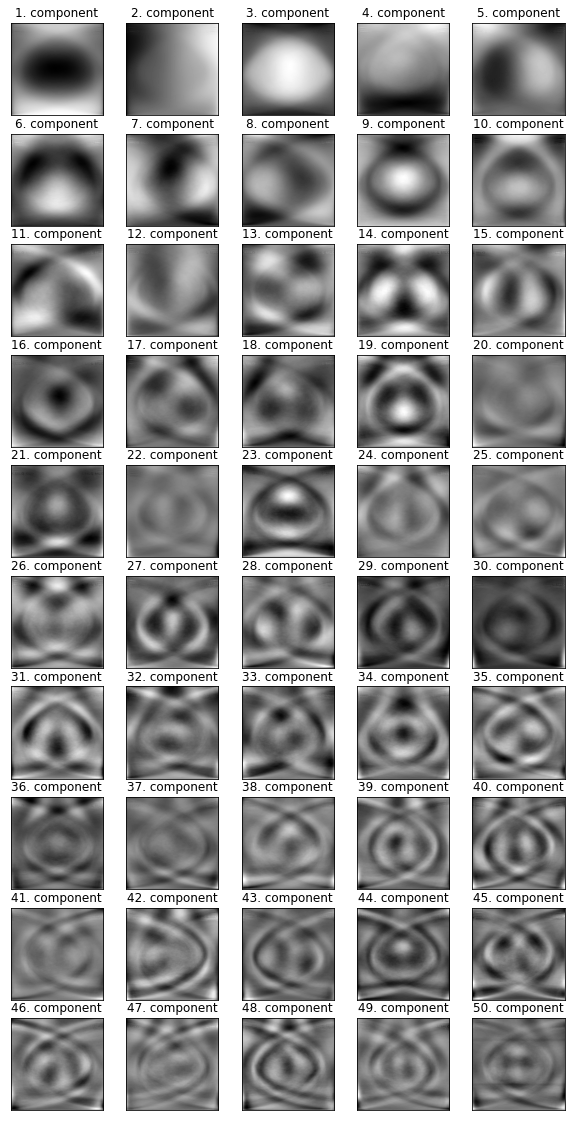

In [28]:
fig, axes = plt.subplots(10, 5, figsize=(10, 20), subplot_kw={'xticks': (), 'yticks': ()})

for i, (component, ax) in enumerate(zip(model.components_, axes.ravel())):
    ax.imshow(component.reshape(256, 256), cmap='gray')
    ax.set_title("{}. component".format((i + 1)))

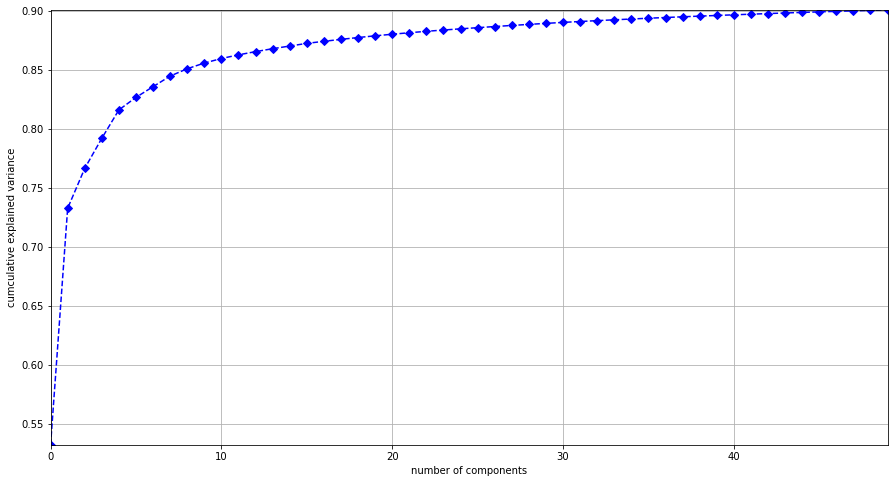

In [29]:
model = pickle.load(open('../feature_extractors/PCA_50_42_256_4.pkl', 'rb'))

fig, axs = plt.subplots(figsize=(15, 8))

axs.plot(model.explained_variance_ratio_.cumsum(), marker='D', linestyle="--", color='blue')
axs.set_title('50 components (Explained variance: {:.4f})'.format(model.explained_variance_ratio_.cumsum()[-1]))
axs.set_xlabel('number of components')
axs.set_ylabel('cumculative explained variance')
axs.margins(x=0,y=0)
plt.grid(axis='both')
plt.show()

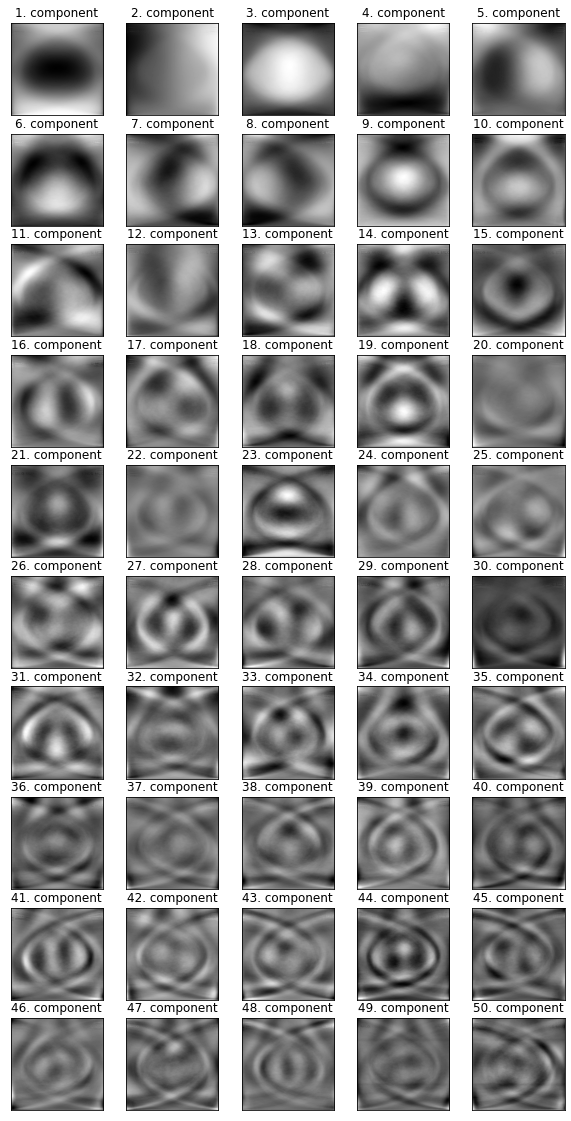

In [30]:
fig, axes = plt.subplots(10, 5, figsize=(10, 20), subplot_kw={'xticks': (), 'yticks': ()})

for i, (component, ax) in enumerate(zip(model.components_, axes.ravel())):
    ax.imshow(component.reshape(256, 256), cmap='gray')
    ax.set_title("{}. component".format((i + 1)))